<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-reviews-logistic-regression/blob/master/Amazon_Fine_Food_Reviews_Analysis_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')
files.upload()

!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip -d amazon-fine-food-reviews-data


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


 98% 245M/251M [00:04<00:00, 33.2MB/s]
100% 251M/251M [00:04<00:00, 53.3MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: amazon-fine-food-reviews-data/Reviews.csv  
  inflating: amazon-fine-food-reviews-data/database.sqlite  
  inflating: amazon-fine-food-reviews-data/hashes.txt  


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm_notebook as tqdm

import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews-data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time Asc""" , con) # LIMIT 50000

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  

In [9]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [10]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

For those on a raw diet, this product is one of the best.  It is a simple snack (made with only two ingredients; dates and cashews), with no preservatives.  Even if you are not a raw foodist, this bar is a healthy snack to be enjoyed by all.  I even convinced by 83 year-old father to try one and he is hooked!


In [13]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

For those on a raw diet this product is one of the best It is a simple snack made with only two ingredients dates and cashews with no preservatives Even if you are not a raw foodist this bar is a healthy snack to be enjoyed by all I even convinced by 83 year old father to try one and he is hooked 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
preprocessed_reviews = []
#  is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [0]:
preprocessed_reviews[1500]

'raw diet product one best simple snack made two ingredients dates cashews no preservatives even not raw foodist bar healthy snack enjoyed even convinced year old father try one hooked'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)

count_vect = CountVectorizer(min_df= 10, ngram_range= (1,2)) #in scikit-learn
train_BoW= count_vect.fit_transform(x_train)
test_BoW= count_vect.transform(x_test)

## [4.3] TF-IDF

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)

train_tfidf= tf_idf_vect.fit_transform(x_train)
test_tfidf= tf_idf_vect.transform(x_test)

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8878289461135864), ('terrific', 0.8831347227096558), ('good', 0.8637110590934753), ('awesome', 0.8473787307739258), ('excellent', 0.8461093902587891), ('wonderful', 0.8064274787902832), ('perfect', 0.7927978038787842), ('nice', 0.7475479245185852), ('decent', 0.7161177396774292), ('amazing', 0.7144061326980591)]
[('nastiest', 0.8167998790740967), ('disgusting', 0.756686270236969), ('greatest', 0.740416944026947), ('best', 0.7298429012298584), ('terrible', 0.7124285697937012), ('horrid', 0.7112972736358643), ('horrible', 0.708044171333313), ('awful', 0.6929646134376526), ('vile', 0.6399281620979309), ('nasty', 0.6343941688537598)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  30490
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'introduces', 'silliness', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'aired', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


291336
50


In [0]:
#W2V for test set:

i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

NameError: ignored

In [0]:
# Saving vectors to a file
import pickle

# An arbitrary collection of objects supported by pickle.
data = sent_vectors

with open('drive/My Drive/sent_vectors_train_LR.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    
print(len(sent_vectors))

data = sent_vectors_test

with open('drive/My Drive/sent_vectors_test_LR.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    
print(len(sent_vectors_test))

291336
72835


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
    

model = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 5000)
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
import pickle

# An arbitrary collection of objects supported by pickle.
data = tfidf_sent_vectors

with open('drive/My Drive/tfidf_sent_vectors_train_LR.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    
print(len(tfidf_sent_vectors))

291336


In [0]:
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())


# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [0]:
import pickle

# An arbitrary collection of objects supported by pickle.
data = tfidf_sent_vectors_test

with open('drive/My Drive/tfidf_sent_vectors_test_LR.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    
print(len(tfidf_sent_vectors_test))

72835


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [21]:
print(final['Score'].value_counts()[1])
print(final['Score'].value_counts()[0])

307061
57110


In [0]:
crossval= 10

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   25.1s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  9.2min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 20.4min finished


GridSearchCV done


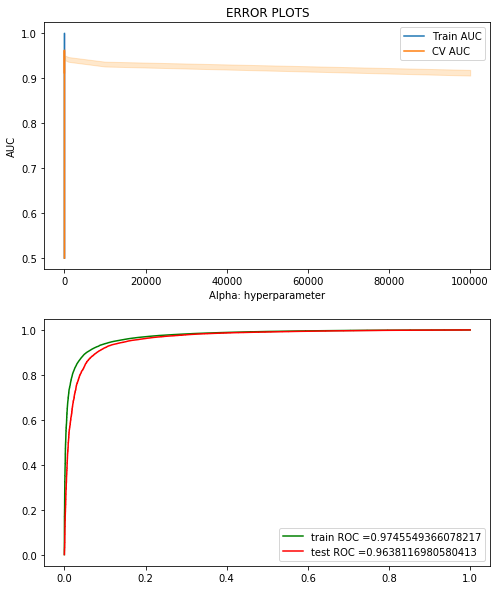


==CONCLUSION==


Best Classifier Score : {'C': 0.1}
Best Estimator : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.9625071438639072

Train confusion matrix: 
[[ 41212   3363]
 [ 19442 227319]]

Test confusion matrix: 
[[11334  1201]
 [ 5033 55267]]

Test Sensitivity or True Positive Rate: 0.69
Test Specificity or False Negative Rate: 0.98


In [23]:
# Please write all the code with proper documentation

powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
model= LogisticRegression(class_weight= 'balanced', penalty='l1')
hyperparameters={
    'C': C_list
}

train= train_BoW
test= test_BoW
score = GridSearchCV(model, hyperparameters, cv= crossval, scoring= 'roc_auc', verbose= 5, n_jobs= -1, return_train_score= True)
score.fit(train, y_train)
print('GridSearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between((C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

CM_BOW_L1= TECM
AUC_BOW_L1= '{:.4f}'.format(score.best_score_)
BEST_BOW_L1= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [24]:
# Please write all the code with proper documentation
best_model.fit(train, y_train)
print('Number of non-zero dimen ', np.count_nonzero(best_model.coef_))

Number of non-zero dimen  4402


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.1s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  68 ta

GridSearchCV done


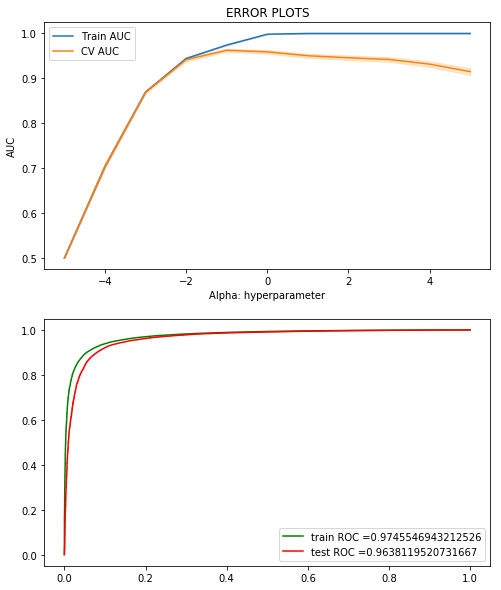


==CONCLUSION==


Best Classifier Score : {'C': 0.1}
Best Estimator : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.9625071565857148

Train confusion matrix: 
[[ 41210   3365]
 [ 19440 227321]]

Test confusion matrix: 
[[11334  1201]
 [ 5033 55267]]

Test Sensitivity or True Positive Rate: 0.69
Test Specificity or False Negative Rate: 0.98


In [25]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
logistic= LogisticRegression(class_weight= 'balanced', penalty='l2')
hyperparameters={
    'C': C_list
}
score = GridSearchCV(model, hyperparameters, cv= crossval, scoring= 'roc_auc', verbose= 5, n_jobs= -1, return_train_score= True)
score.fit(train_BoW, y_train)
print('GridSearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))


CM_BOW_L2= TECM
AUC_BOW_L2= '{:.4f}'.format(score.best_score_)
BEST_BOW_L2= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [26]:
# Please write all the code with proper documentation
import random
# check whether we can use  weight vector as feature importance
# weight vector without adding noise
newtrain= train
local_model= best_model
local_model.fit(newtrain, y_train)
w_before= local_model.coef_ 
newtrain.data= train.data+ np.random.normal(loc=0,scale=0.0001,size=train.data.shape)
best_model.fit(newtrain, y_train)
print('sparcity Before: {}\nVector: {}'.format(np.count_nonzero(w_before), w_before))
print('sparcity After: {}\nVector: {}'.format(np.count_nonzero(local_model.coef_), local_model.coef_))

print('Difference: {}'.format(np.sum(np.abs(w_before- local_model.coef_))))



sparcity Before: 4398
Vector: [[0. 0. 0. ... 0. 0. 0.]]
sparcity After: 4398
Vector: [[0. 0. 0. ... 0. 0. 0.]]
Difference: 2.565781356038514


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation
best_model.fit(train, y_train)
features = count_vect.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.coef_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 positive features: \n\n', features_coef.head(10))

Top 10 positive features: 

                         coef
features                    
not disappointed    3.514869
four stars          2.687853
not overpowering    2.494742
no bitter           2.182181
not weak            2.046049
never disappointed  1.902732
not disappoint      1.878315
hooked              1.875604
go wrong            1.872379
not bitter          1.869566


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [28]:
# Please write all the code with proper documentation
features = count_vect.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.coef_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 negative features: \n\n', features_coef.tail(10))

Top 10 negative features: 

                     coef
features                
not purchasing -2.156861
disappointment -2.198316
not happy      -2.239800
no thanks      -2.329126
wanted like    -2.346674
worst          -2.463115
disappointing  -2.497227
not impressed  -2.621088
not worth      -2.982380
two stars      -4.220168


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 110 out of 110 | elapsed: 13.1min finished


GridsearchCV done


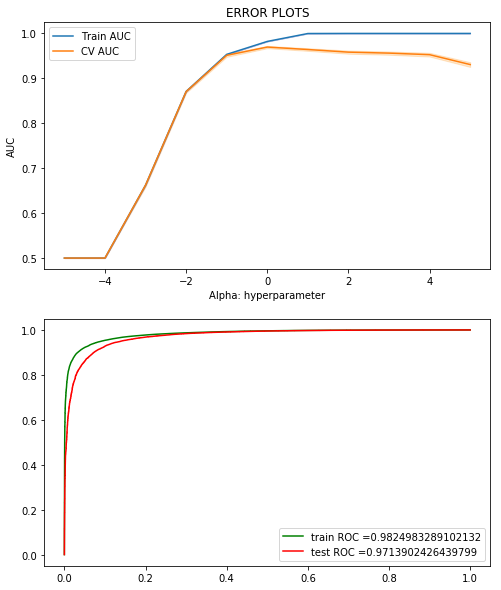


==CONCLUSION==


Best Classifier Score : {'C': 1.0}
Best Estimator : LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.9696602256784799

Train confusion matrix: 
[[ 42009   2566]
 [ 17839 228922]]

Test confusion matrix: 
[[11356  1179]
 [ 4740 55560]]

Test Sensitivity or True Positive Rate: 0.71
Test Specificity or False Negative Rate: 0.98


In [29]:
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
model= LogisticRegression(class_weight= 'balanced', penalty='l1')
hyperparameters={
    'C': C_list
}

train= train_tfidf
test= test_tfidf
score = GridSearchCV(model, hyperparameters, cv= crossval, scoring= 'roc_auc', verbose= 5, n_jobs= 2, return_train_score= True)
score.fit(train, y_train)
print('GridsearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

CM_TFIDF_L1= TECM
AUC_TFIDF_L1= '{:.4f}'.format(score.best_score_)
BEST_TFIDF_L1= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   24.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  9.1min
[Parallel(n_jobs=2)]: Done 110 out of 110 | elapsed: 62.0min finished


GridsearchCV done


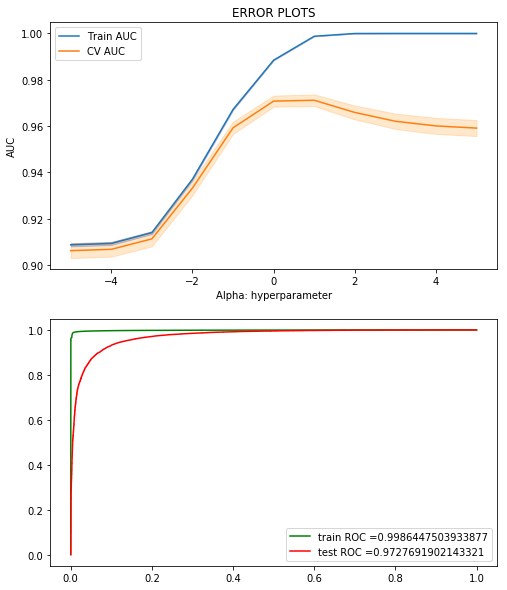


==CONCLUSION==


Best Classifier Score : {'C': 10.0}
Best Estimator : LogisticRegression(C=10.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.9711377066910752

Train confusion matrix: 
[[ 44423    152]
 [  5014 241747]]

Test confusion matrix: 
[[10876  1659]
 [ 3007 57293]]

Test Sensitivity or True Positive Rate: 0.78
Test Specificity or False Negative Rate: 0.97


In [30]:
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
model= LogisticRegression(class_weight= 'balanced', penalty='l2')
hyperparameters={
    'C': C_list
}

train= train_tfidf
test= test_tfidf
score = GridSearchCV(model, hyperparameters, cv= crossval, scoring= 'roc_auc', verbose= 5, n_jobs= 2, return_train_score= True)
score.fit(train, y_train)
print('GridsearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

CM_TFIDF_L2= TECM
AUC_TFIDF_L2= '{:.4f}'.format(score.best_score_)
BEST_TFIDF_L2= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [31]:
# Please write all the code with proper documentation
best_model.fit(train, y_train)
features = count_vect.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.coef_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 positive features: \n\n', features_coef.head(10))

Top 10 positive features: 

                        coef
features                   
great             23.799591
delicious         21.878888
not disappointed  21.153013
best              18.277598
perfect           18.021874
good              17.551058
excellent         15.465583
pleased           15.329954
happy             14.806226
loves             14.332481


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [32]:
# Please write all the code with proper documentation
features = count_vect.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.coef_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 negative features: \n\n', features_coef.tail(10))

Top 10 negative features: 

                      coef
features                 
awful          -15.206459
terrible       -15.581818
not good       -16.069431
disappointment -16.129426
disappointing  -17.362639
not recommend  -18.290538
disappointed   -19.468573
worst          -19.749338
not worth      -20.535785
two stars      -21.155927


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [33]:
# Read train and test vectoriser from saved data
import pickle

with open('drive/My Drive/sent_vectors_train_LR.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    sent_vectors = pickle.load(f)
    
print(len(sent_vectors))


with open('drive/My Drive/sent_vectors_test_LR.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    sent_vectors_test = pickle.load(f)
    
print(len(sent_vectors_test))

291336
72835


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 75.4min finished


GridsearchCV done


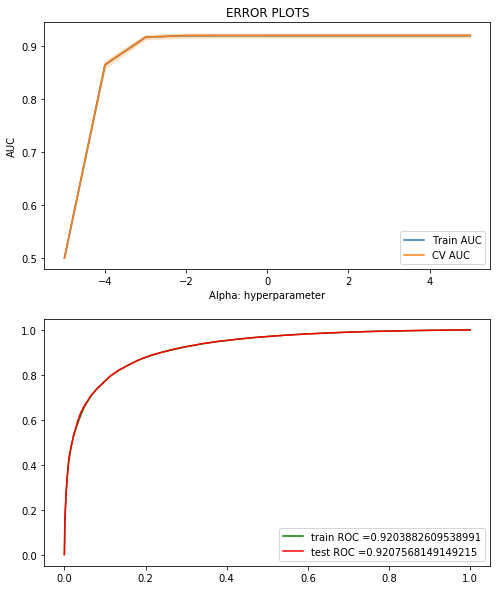


==CONCLUSION==


Best Classifier Score : {'C': 0.1}
Best Estimator : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.9203537576866786

Train confusion matrix: 
[[ 38028   6547]
 [ 41158 205603]]

Test confusion matrix: 
[[10793  1742]
 [10517 49783]]

Test Sensitivity or True Positive Rate: 0.51
Test Specificity or False Negative Rate: 0.97


In [34]:
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
model= LogisticRegression(class_weight= 'balanced', penalty='l1')
hyperparameters={
    'C': C_list
}

train= sent_vectors
test= sent_vectors_test
score = GridSearchCV(model, hyperparameters, cv= crossval, scoring= 'roc_auc', verbose= 5, n_jobs= -1, return_train_score= True)
score.fit(train, y_train)
print('GridsearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

CM_AVGW2V_L1= TECM
AUC_AVGW2V_L1= '{:.4f}'.format(score.best_score_)
BEST_AVGW2V_L1= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 21.7min finished


GridsearchCV done


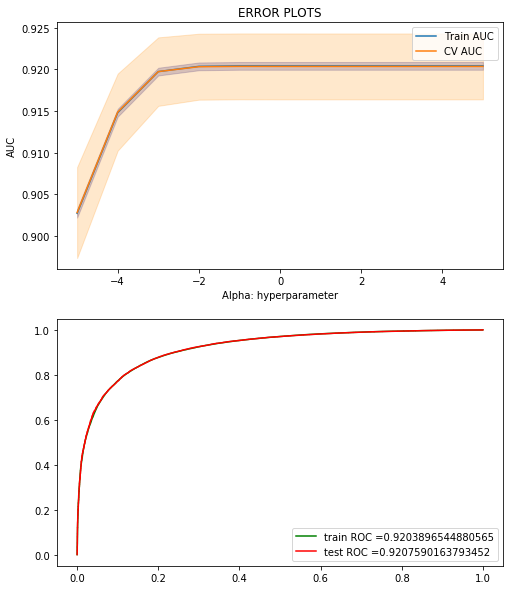


==CONCLUSION==


Best Classifier Score : {'C': 0.1}
Best Estimator : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.9203489458082939

Train confusion matrix: 
[[ 38025   6550]
 [ 41155 205606]]

Test confusion matrix: 
[[10789  1746]
 [10512 49788]]

Test Sensitivity or True Positive Rate: 0.51
Test Specificity or False Negative Rate: 0.97


In [35]:
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
model= LogisticRegression(class_weight= 'balanced', penalty='l2')
hyperparameters={
    'C': C_list
}

train= sent_vectors
test= sent_vectors_test
score = GridSearchCV(model, hyperparameters, cv= crossval, scoring= 'roc_auc', verbose= 5, n_jobs= -1, return_train_score= True)
score.fit(train, y_train)
print('GridsearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

CM_AVGW2V_L2= TECM
AUC_AVGW2V_L2= '{:.4f}'.format(score.best_score_)
BEST_AVGW2V_L2= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [36]:
# Read train and test vectoriser from saved data
import pickle
tfidf_sent_vectors= []
tfidf_sent_vectors_test= []

with open('drive/My Drive/tfidf_sent_vectors_train_LR.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    tfidf_sent_vectors = pickle.load(f)
    
print(len(tfidf_sent_vectors))


with open('drive/My Drive/tfidf_sent_vectors_test_LR.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    tfidf_sent_vectors_test = pickle.load(f)
    
print(len(tfidf_sent_vectors_test))

291336
72835


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 87.7min finished


GridsearchCV done


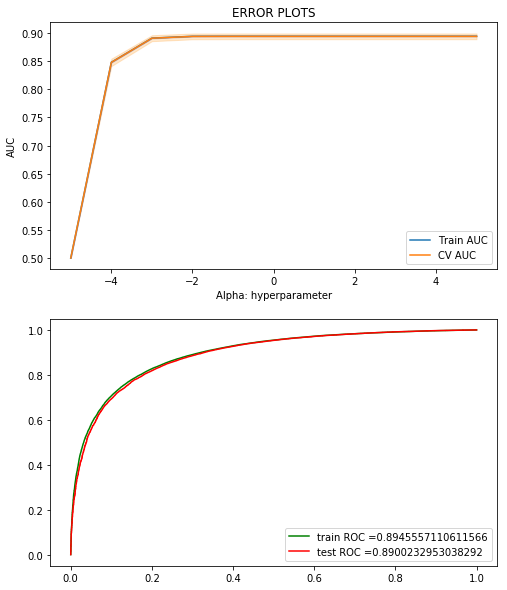


==CONCLUSION==


Best Classifier Score : {'C': 0.1}
Best Estimator : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.894347395087953

Train confusion matrix: 
[[ 36637   7938]
 [ 47585 199176]]

Test confusion matrix: 
[[10302  2233]
 [12161 48139]]

Test Sensitivity or True Positive Rate: 0.46
Test Specificity or False Negative Rate: 0.96


In [37]:
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
model= LogisticRegression(class_weight= 'balanced', penalty='l1')
hyperparameters={
    'C': C_list
}

train= tfidf_sent_vectors
test= tfidf_sent_vectors_test
score = GridSearchCV(model, hyperparameters, cv= crossval , scoring= 'roc_auc', verbose= 5, n_jobs= -1, return_train_score= True)
score.fit(train, y_train)
print('GridsearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

CM_TFIDFW2V_L1= TECM
AUC_TFIDFW2V_L1= '{:.4f}'.format(score.best_score_)
BEST_TFIDFW2V_L1= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed: 22.5min finished


GridsearchCV done


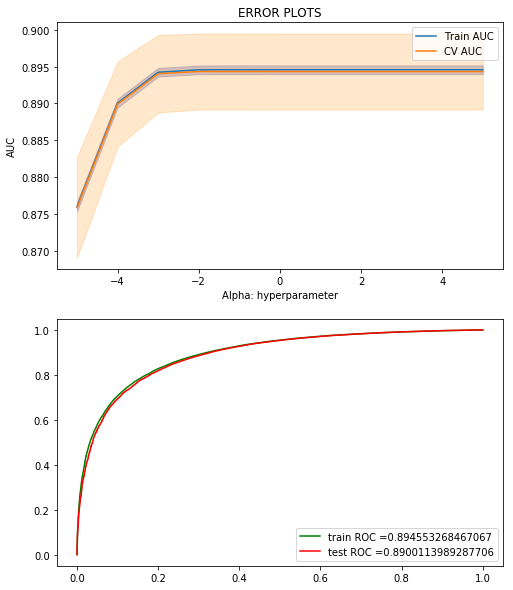


==CONCLUSION==


Best Classifier Score : {'C': 0.1}
Best Estimator : LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

AUC Score: 0.8943355361844452

Train confusion matrix: 
[[ 36733   7842]
 [ 48308 198453]]

Test confusion matrix: 
[[10324  2211]
 [12296 48004]]

Test Sensitivity or True Positive Rate: 0.46
Test Specificity or False Negative Rate: 0.96


In [38]:
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
C_list = (list(np.power(([10]*len(powers)), powers)))
model= LogisticRegression(class_weight= 'balanced', penalty='l2')
hyperparameters={
    'C': C_list
}

train= tfidf_sent_vectors
test= tfidf_sent_vectors_test
score = GridSearchCV(model, hyperparameters, cv= crossval, scoring= 'roc_auc', verbose= 5, n_jobs= -1, return_train_score= True)
score.fit(train, y_train)
print('GridsearchCV done')

train_auc= score.cv_results_['mean_train_score']
train_auc_std= score.cv_results_['std_train_score']
cv_auc = score.cv_results_['mean_test_score'] 
cv_auc_std= score.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(C_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2, color='darkblue')

# Plotting CV AUC
ax1.plot(np.log10(C_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(C_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')
ax1.legend()

best_model= score.best_estimator_

#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_model.predict_proba(test)[:,1])

ax2= fig.add_subplot(212)
ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

results = score.best_params_
print('\n==CONCLUSION==\n')
print('\nBest Classifier Score :', results)
print('Best Estimator :', score.best_estimator_)
print('\nAUC Score: {}\n'.format(score.best_score_))

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))

CM_TFIDFW2V_L2= TECM
AUC_TFIDFW2V_L2= '{:.4f}'.format(score.best_score_)
BEST_TFIDFW2V_L2= score.best_estimator_

print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))


# [6] Conclusions

In [39]:
print(AUC_BOW_L1)

0.9625


+-------------+------------------------------------------+---------------------------------------------------------------------------------+--------+
|  Vectorizer |                  Model                   |                                  Hyperparameter                                 |  AUC   |
+-------------+------------------------------------------+---------------------------------------------------------------------------------+--------+
|    BOW L1   | Logistic Regression with L1 penalisation |          LogisticRegression(C=0.1, class_weight='balanced', dual=False,         | 0.9625 |
|             |                                          |                       fit_intercept=True, intercept_scaling=1, l1_ratio=None,   |        |
|             |                                          |                    max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', |        |
|             |                                          |                      random_state=None, s

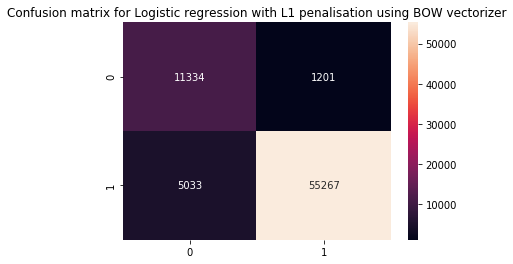

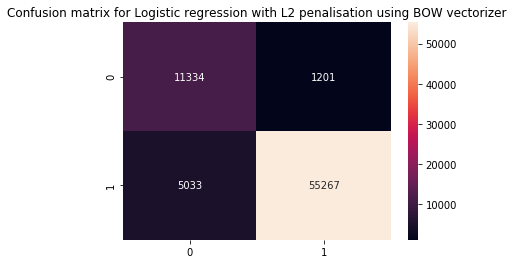

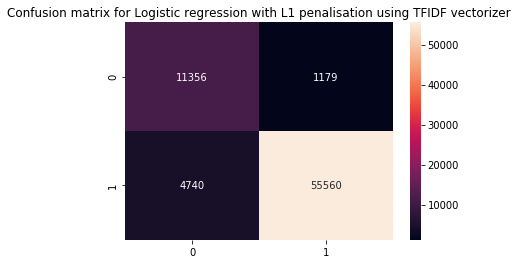

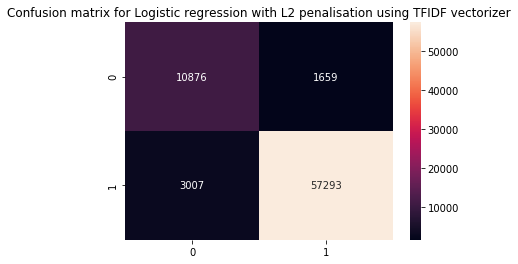

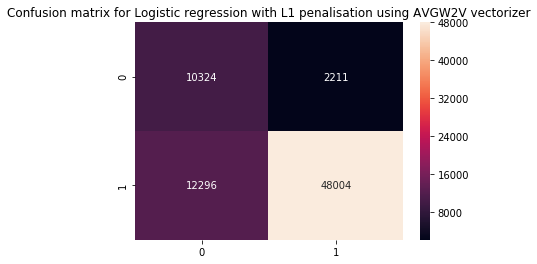

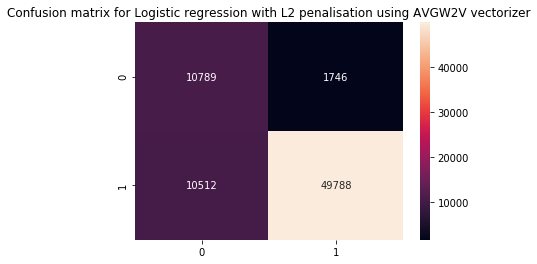

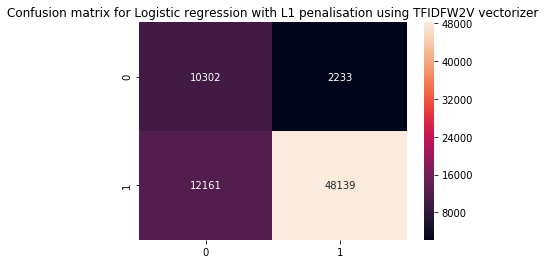

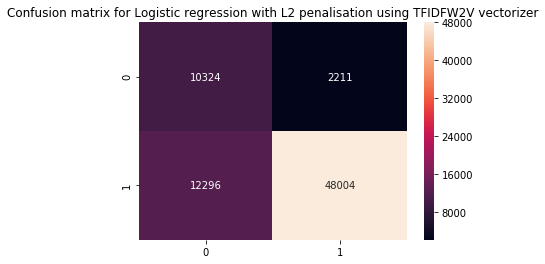

In [40]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
import seaborn as sns
x= PrettyTable(["Vectorizer", "Model", "Hyperparameter", "AUC"])

x.add_row(['BOW L1', 'Logistic Regression with L1 penalisation', BEST_BOW_L1, AUC_BOW_L1])
x.add_row(['BOW L2', 'Logistic Regression with L2 penalisation', BEST_BOW_L2, AUC_BOW_L2])

x.add_row(['TFIDF L1', 'Logistic Regression with L1 penalisation', BEST_TFIDF_L1, AUC_TFIDF_L1])
x.add_row(['TFIDF L2', 'Logistic Regression with L2 penalisation', BEST_TFIDF_L2, AUC_TFIDF_L2])

x.add_row(['AVGW2V L1', 'Logistic Regression with L1 penalisation', BEST_AVGW2V_L1, AUC_AVGW2V_L1])
x.add_row(['AVGW2V L2', 'Logistic Regression with L2 penalisation', BEST_AVGW2V_L2, AUC_AVGW2V_L2])

x.add_row(['TFIDFW2V L1', 'Logistic Regression with L1 penalisation', BEST_TFIDFW2V_L1, AUC_TFIDFW2V_L1])
x.add_row(['TFIDFW2V L2', 'Logistic Regression with L2 penalisation', BEST_TFIDFW2V_L2, AUC_TFIDFW2V_L2])

print(x)

CM_AVGW2V_L1= TECM
AUC_AVGW2V_L1= '{:.4f}'.format(score.best_score_)
BEST_AVGW2V_L1= score.best_estimator_


ax= sns.heatmap(CM_BOW_L1, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L1 penalisation using BOW vectorizer')
plt.show()

ax= sns.heatmap(CM_BOW_L2, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L2 penalisation using BOW vectorizer')
plt.show()
ax= sns.heatmap(CM_TFIDF_L1, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L1 penalisation using TFIDF vectorizer')
plt.show()
ax= sns.heatmap(CM_TFIDF_L2, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L2 penalisation using TFIDF vectorizer')
plt.show()
ax= sns.heatmap(CM_AVGW2V_L1, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L1 penalisation using AVGW2V vectorizer')
plt.show()
ax= sns.heatmap(CM_AVGW2V_L2, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L2 penalisation using AVGW2V vectorizer')
plt.show()
ax= sns.heatmap(CM_TFIDFW2V_L1, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L1 penalisation using TFIDFW2V vectorizer')
plt.show()
ax= sns.heatmap(CM_TFIDFW2V_L2, annot=True, fmt="d")
ax.set_title('Confusion matrix for Logistic regression with L2 penalisation using TFIDFW2V vectorizer')
plt.show()

In [41]:
!ls

amazon-fine-food-reviews-data  drive	    sample_data
amazon-fine-food-reviews.zip   kaggle.json
